In [1]:
import torch 
import torch.distributions.constraints as constraints
!pip install pyro-ppl==1.3.0
import pyro
import pyro.distributions as dist
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

     |████████████████████████████████| 495 kB 4.9 MB/s 


In [2]:
type(fashion_mnist)
dir(fashion_mnist)
dataset = fashion_mnist.load_data()
print("Dataset:\ntype:",type(dataset), "\nlen: ", len(dataset))
print("\nDataset[0]:\ntype:", type(dataset[0]), "\nlen: ", len(dataset[0]))
print("\nDataset[0][0]:\ntype:", type(dataset[0][0]), "\nlen: ", len(dataset[0][0]), "\nshape: ", dataset[0][0].shape)

dataset[0][0][:5]
#dataset[0][1][:10]

dataset[1][0].shape

4423680/4422102 [==============================] - 0s 0us/step
Dataset:
type: <class 'tuple'> 
len:  2

Dataset[0]:
type: <class 'tuple'> 
len:  2

Dataset[0][0]:
type: <class 'numpy.ndarray'> 
len:  60000 
shape:  (60000, 28, 28)


(10000, 28, 28)

Dataset is a tuple composed of two elements, these 2 elements are themselves tuples composed of two elements, so to access the first element of the first typle I have to do dataset[0][0]. As you can see, that is a numpy multid array.
 - dataset[0][0]: contains trainX
 - dataset[0][1]: contains trainY associated to trainX
 - dataset[1][0]: contains testX
 - dataset[1][1]: contains testY

In [3]:
(trainX, trainY), (testX, testY) = dataset
type(trainX)

trainX.shape
trainY.shape

testX.shape
testY.shape

(10000,)

## show some images of the dataset

In [14]:
label = { 0: "T-shirt/Top",
          1: "Trouser",
          2: "Pullover",
          3: "Dress",
          4: "Coat", 
          5: "Sandal", 
          6: "Shirt",
          7: "Sneaker",
          8: "Bag",
          9: "Ankle Boot"
        }

In [ ]:
plt.imshow(trainX[0], cmap="gray")
label[testY[0]]

## Feature extraction
 - raw pixels
 - edge extraction
 - HOG features

edge extraction

In [ ]:
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v

In [ ]:
image = trainX[0]

#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(image)

imshow(edges_prewitt_horizontal, cmap='gray')

edges_prewitt_horizontal.shape
len(edges_prewitt_horizontal[1])

It produces another image at the end of the day, so I don't think it will speed up that much the learning of a classificator

In [ ]:
#edge extracting for each image

start_time = time.time()

trainX.shape
trainX = trainX.reshape(60000,28,28)
len(trainX)
for i in range(len(trainX)):
  trainX[i] = torch.tensor(prewitt_h(trainX[i]))

print(f"--- {round((time.time() - start_time),2)} seconds ---")

## Reshaping

In [4]:
trainX = np.reshape(trainX, (60000,784))
testX = np.reshape(testX, (10000,784))

trainX = torch.tensor(trainX)
trainY = torch.tensor(trainY)
testX = torch.tensor(testX)
testY = torch.tensor(testY)

print(type(trainX))
trainX.shape

<class 'torch.Tensor'>


torch.Size([60000, 784])

In [ ]:
# one hot encoding 
a = to_categorical(trainY)
b = to_categorical(testY)


60000

In [5]:
# changing torch from byte to float
trainX = trainX.float()
testX = testX.float()

In [6]:
# Normalization
trainX /= 255
testX /= 255

In [42]:
#print(torch.unique(trainY[:1000], return_counts=True))
#print(torch.unique(testY[:1000], return_counts=True))

# reducing size of trainX and trainY to 5000 images, and 1000 for testX and testY
# the images are random, so just need to select the first

trainX = trainX[:5000]
trainY = trainY[:5000]

#testX = testX[:1000]
#testY = testY[:1000]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

torch.Size([5000, 784]) torch.Size([5000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
#testing for GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Trial cells

In [ ]:
### Trial cell

n_obs, n_features = trainX.shape
n_labels = 10

w = pyro.sample("w", dist.Normal(torch.zeros(n_features, n_labels), 
                                   torch.ones(n_features, n_labels) )
                 )

b = pyro.sample("b", dist.Normal(torch.zeros(n_labels), torch.ones(n_labels)))

# since torch.mm requires the 2 input torch tensors (matrices) to be the same type (not the dtype), I have to convert trainX (which is a Byte tensor), to
# a floatTensor (because w is a floatTensor), the following functions transform one into the other
#s = w.byte()
#s = s.float()
#s.type()
trainX = trainX.float()

yhat = torch.mm(trainX,w) 

yo=yhat+b

b.shape

In [ ]:
### Trial cell

a = torch.randn((4,2))
b = torch.tensor([1,0])
print(a)
print(b)
print(a+b)

In [ ]:
### Trial cell

b = torch.tensor([[1,1,1,1,1],[9,9,9,9,9]])
print(b)
b.shape

In [ ]:
#Trial cell

mambo = trainX[:2]
mambo = mambo.float()
print(mambo[0])
for i in range(mambo.shape[0]):
  for j in range(mambo.shape[1]):
    mambo[i][j] = mambo[i][j]/255

mambo[0]

## Stochastic variational inference

In [ ]:
def model(x, y):
  '''
  x = trainX
  y = trainY
  '''
  n_obs, n_features = x.shape
  n_labels = 10
  x = x.float()

  # priors on w and b
  w = pyro.sample("w", dist.Normal(torch.zeros(n_features, n_labels), 
                                   torch.ones(n_features, n_labels) )
                 )
  
  b = pyro.sample("b", dist.Normal(torch.zeros(n_labels), torch.ones(n_labels)))

  yhat = torch.mm(x,w) + b

  p = torch.softmax(yhat, dim=-1)

  with pyro.plate("data", len(y)):
    y = pyro.sample("y", dist.Categorical(probs=p), obs=y)


##################### guide ###########################################
def guide(x,y):
  n_obs, n_features = x.shape
  n_labels = 10
  x=x.float

  w_loc = pyro.param("w_loc", torch.rand(n_features, n_labels))
  w_scale = pyro.param("w_scale", torch.rand(n_features, n_labels))
  w = pyro.sample("w", dist.Normal(w_loc, w_scale))

  b_loc = pyro.param("b_loc", torch.rand(n_labels))
  b_scale = pyro.param("b_scale", torch.rand(n_labels), constraint=constraints.positive)
  b = pyro.sample("b", dist.Normal(b_loc, b_scale))


In [ ]:
#SVI model run

start_time = time.time()

model_svi = pyro.infer.SVI(model=model, guide=guide, optim=pyro.optim.Adam({'lr':0.0001}), loss=pyro.infer.Trace_ELBO())

# optimizers: pyro.optim.Name(optim_args) where optim_args is a dict
# optim=pyro.optim.Adam({'lr':0.0001})
# optim=pyro.optim.SGD({'lr':0.01}) non funziona


losses = []
for step in range(10000):
  loss = model_svi.step(trainX, trainY)/len(trainX)
  losses.append(loss)
  if step % 1000 == 0:
    print(f"step:{step} ; loss = {loss}")  
  
print(f"--- {round((time.time() - start_time)/60,2)} minutes ---") 

step:0 ; loss = 12.528853701853752
step:1000 ; loss = 9.18742225868702
step:2000 ; loss = 7.7105551460266115
step:3000 ; loss = 7.245757773375511
step:4000 ; loss = 5.300987485599518
step:5000 ; loss = 5.850775528860092
step:6000 ; loss = 4.989468690681457
step:7000 ; loss = 5.231475929546356
step:8000 ; loss = 4.089465017461777
step:9000 ; loss = 4.778019976139069
--- 2.55 minutes ---


In [ ]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

print(f"w has shape ({inferred_w.shape[0]},{inferred_w.shape[1]})")
print(f"b has shape ({inferred_b.shape[0]})\n")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w has shape (784,10)
b has shape (10)



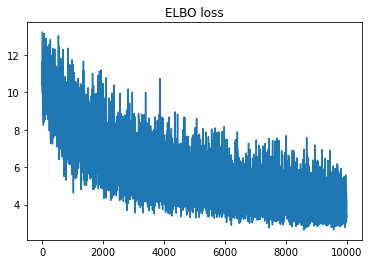

In [ ]:
plt.title("ELBO loss")
plt.plot(losses)

In [ ]:
w = inferred_w
b = inferred_b

def predict_class(x,w,b):
  n_obs, n_feat = x.shape

  x = x.float()
  scores = torch.mm(x,w) + b.repeat(n_obs, 1)

  probs = torch.softmax(scores, dim=-1)

  return torch.argmax(probs, dim=-1) #returns the index corresponding to max value of probs

  # probs is a vector of probability values for each class (in our case 10 dim vector)

In [ ]:
# compute test accuracy
correct_predictions = (predict_class(testX,w,b) == testY).sum().item()
print(f"test accuracy over whole test set = {correct_predictions/len(testX)*100:.1f}%")

test accuracy over whole test set = 71.9%


In [ ]:
y_pred = predict_class(testX,w,b)

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

class_report = classification_report(testY, y_pred )
print("\n\nClassification report:\n", class_report)

confusion matrix:
 [[797   5  15 112  14   0  32   0  22   3]
 [ 17 894  14  61  11   0   1   0   2   0]
 [ 18   0 647  18 263   0  31   0  23   0]
 [ 31  13   7 877  36   1  31   0   4   0]
 [  1  10 237  97 627   0  16   0  12   0]
 [  1   0   0   3   0 481   0 260  13 242]
 [217   2 190 107 311   0 134   0  39   0]
 [  0   0   0   0   0  17   0 869   1 113]
 [  4   0  14  25  12   5   7   9 921   3]
 [  0   0   0   2   0   5   0  47   2 944]]


Classification report:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      1000
           1       0.97      0.89      0.93      1000
           2       0.58      0.65      0.61      1000
           3       0.67      0.88      0.76      1000
           4       0.49      0.63      0.55      1000
           5       0.94      0.48      0.64      1000
           6       0.53      0.13      0.21      1000
           7       0.73      0.87      0.80      1000
           8       0.89      0.92    

How to improve? 
 - try extraction feature
 - normalization of values of pixels

## HMC

In [ ]:
from pyro.infer import MCMC, HMC, NUTS

In [ ]:
def model1(x, y):
  '''
  x = trainX
  y = trainY
  '''
  n_obs, n_features = x.shape
  n_labels = 10
  x = x.float()

  w = pyro.sample("w", dist.Normal(torch.zeros(n_features, n_labels), 
                                   torch.ones(n_features, n_labels) )
                 )
  
  b = pyro.sample("b", dist.Normal(torch.zeros(n_labels), torch.ones(n_labels)))

  yhat = torch.mm(x,w) + b

  p = torch.softmax(yhat, dim=-1)

  with pyro.plate("data", len(y)):
    y = pyro.sample("y", dist.Categorical(probs=p), obs=y)

In [ ]:
start_time = time.time()

nuts_kernel = NUTS(model1)
mcmc = MCMC(nuts_kernel, warmup_steps=40, num_samples=6)
posterior = mcmc.run(x=trainX, y=trainY)

print("\n\n")
print(f"--- {round((time.time() - start_time)/60,2)} minutes ---") 

Warmup:  70%|██████▉   | 32/46 [08:26, 17.24s/it, step size=6.01e-05, acc. prob=0.741]

KeyboardInterrupt: ignored

In [ ]:
mcmc.summary()

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/util.py:416: UserWarning: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/util.py", line 414, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/pyro/ops/stats.py", line 184, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/usr/local/lib/python3.7/dist-packages/pyro/ops/stats.py", line 135, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/usr/local/lib/python3.7/dist-packages/pyro/ops/stats.py", line 112, in autocorrelation
    freqvec = torch.rfft(centered_signal, signal_ndim=1, onesided=False)
AttributeError: module 'torch' has no attribute 'rfft'

  warnings.warn(tb.format_exc())


AssertionError: ignored

In [ ]:
mcmc_samples = mcmc.get_samples()
print(mcmc_samples.keys())

In [ ]:
def predict_class(x,w,b):
  n_obs, n_feat = x.shape

  x = x.float()
  scores = torch.mm(x,w) + b.repeat(n_obs, 1)

  probs = torch.softmax(scores, dim=-1)

  return torch.argmax(probs, dim=-1)

In [ ]:
# compute test accuracy
correct_predictions = (predict_class(testX,w,b) == testY).sum().item()
print(f"test accuracy over whole test set = {correct_predictions/len(testX)*100:.1f}%")

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

In [ ]:
start_time = time.time()

rfc = RandomForest()
rfc.fit(trainX,trainY)

print(f"--- {round((time.time() - start_time)/60,2)} minutes ---") 

--- 1.76 minutes ---


In [ ]:
preds = rfc.predict(testX)

print(classification_report(testY,preds))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.80      0.78      1000
           3       0.88      0.90      0.89      1000
           4       0.77      0.81      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000



## Naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
st_time = time.time()

naiveBayes = GaussianNB()
naiveBayes.fit(trainX, trainY)

print(f"--- {(time.time() - st_time)} seconds ---") 

--- 0.40868234634399414 seconds ---


In [ ]:
y_pred = naiveBayes.predict(testX)
print(classification_report(testY, y_pred))

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

In [ ]:
param = naiveBayes.get_params()
param

{'priors': None, 'var_smoothing': 1e-09}

## Gaussian process classification

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn

In [ ]:
kernel = gp_sklearn.kernels.RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel)

gp_time = time.time()

gpc.fit(trainX, trainY)

print(f"---{time.time()-gp_time} seconds ---")

KeyboardInterrupt: ignored

In [ ]:
y_pred = gpc.predict_proba(testX)
print(classification_report(testY, y_pred))

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

## Logistic regression

By default max_iter = 100 and the optimizer for finding best set of params is solver = 'lbfgs'. Whit this setting, as the output states, the model did not converge in 100 iterations. 

Among the possible algorithms, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss. ‘liblinear’ is limited to one-versus-rest schemes, but as the documentation suggest, is good for small datasets, while 'sag' and 'saga' reach convergence faster for big datasets.
multi_class ='multinomial' to handle it as actual multinomial log reg and not one vs all

Consider diminishing tolerance to ensure faster convergence, default is 1e-4

The “saga” solver is a variant of “sag” that also supports the non-smooth penalty="l1". This is therefore the solver of choice for sparse multinomial logistic regression.

The “lbfgs” solver is used by default for its robustness. For large datasets the “saga” solver is usually faster

https://scikit-learn.org/stable/modules/linear_model.html#id26

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [7]:
from sklearn.linear_model import LogisticRegression

In [38]:
tol = 0.001
max_iter = 5000
multi_class = 'multinomial'

# train: 5000 images, test: 10000

In [ ]:
# lgbfs

startTime = time.time()

logregmodel = LogisticRegression(tol = tol, solver='lbfgs', max_iter=max_iter, multi_class=multi_class, n_jobs=-1)
logregmodel.fit(trainX, trainY)

print(f"---{time.time()-startTime} seconds ---")

In [ ]:
y_pred = logregmodel.predict(testX)
print(classification_report(testY, y_pred))

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.76      0.75      1000
           5       0.94      0.92      0.93      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.93      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

confusion matrix:
 [[806   2  11  53   4   2 111   0  11   0]
 [  4 958   3  25   4   0   3   1   2   0]
 [ 25   3 739  10 124   0  86   1  12   0]
 [ 24  17  18 861  30   0  39   0  11   0]
 [  0   2 115  36 764   0  76   0   7   0]
 [  0  

In [43]:
# sag
t = time.time()

sag_lrm = LogisticRegression(tol=tol, solver='sag', max_iter=max_iter, multi_class=multi_class, n_jobs=-1)
sag_lrm.fit(trainX, trainY)

print(f"----{round(time.time()-t, 3)} seconds ----")

----0.225 seconds ----


In [45]:
y_pred = sag_lrm.predict(testX)

cr = classification_report(testY, y_pred)
print(cr)

labels = ['T-shirt','Trousers','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
cf = confusion_matrix(testY, y_pred)
df = pd.DataFrame(cf, index=labels, columns=labels)
df
#print("confusion matrix:\n", cf)

              precision    recall  f1-score   support

           0       0.92      0.38      0.54      1000
           1       0.99      0.90      0.94      1000
           2       0.80      0.45      0.57      1000
           3       0.77      0.83      0.80      1000
           4       0.55      0.88      0.67      1000
           5       0.89      0.80      0.84      1000
           6       0.39      0.57      0.46      1000
           7       0.80      0.93      0.86      1000
           8       0.94      0.87      0.91      1000
           9       0.91      0.87      0.89      1000

    accuracy                           0.75     10000
   macro avg       0.79      0.75      0.75     10000
weighted avg       0.79      0.75      0.75     10000



,T-shirt,Trousers,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt,383,3,11,89,16,1,487,0,10,0
Trousers,0,902,8,56,23,0,9,0,2,0
Pullover,4,0,447,10,316,4,215,0,4,0
Dress,3,5,5,830,75,1,79,0,2,0
Coat,0,1,30,32,878,0,55,0,4,0
Sandal,1,0,0,2,1,795,0,127,11,63
Shirt,27,1,60,38,279,4,575,0,16,0
Sneaker,0,0,0,0,0,46,0,929,0,25
Bag,0,0,0,13,20,16,70,12,869,0
Ankle boot,0,0,0,2,0,26,2,99,2,869


In [ ]:
# saga but with L1 pen norm (the only one among sag saga and lbfgs that can do it)
s = time.time()

saga_lrm = LogisticRegression(penalty='l1', tol=tol, solver='saga', max_iter=max_iter, multi_class=multi_class, n_jobs=-1)
saga_lrm.fit(trainX, trainY)

print(f"----{round(time.time()-s, 3)} seconds ----")

KeyboardInterrupt: ignored

In [ ]:
y_pred = saga_lrm.predict(testX)
print(classification_report(testY, y_pred))

cf = confusion_matrix(testY, y_pred)
print("confusion matrix:\n", cf)

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.73      0.74      0.73      1000
           3       0.83      0.87      0.85      1000
           4       0.73      0.76      0.75      1000
           5       0.94      0.92      0.93      1000
           6       0.63      0.57      0.60      1000
           7       0.91      0.94      0.92      1000
           8       0.93      0.93      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

confusion matrix:
 [[805   3  15  51   6   4 106   0  10   0]
 [  3 959   3  24   5   0   4   0   2   0]
 [ 24   4 736  11 126   0  85   1  13   0]
 [ 27  12  17 867  32   0  35   0  10   0]
 [  0   2 112  35 762   0  79   0  10   0]
 [  0  

In [ ]:
coef = saga_lrm.coef_.copy()
type(coef)
coef.shape

(10, 784)

Text(0.5, 0.98, 'Classification vector for...')

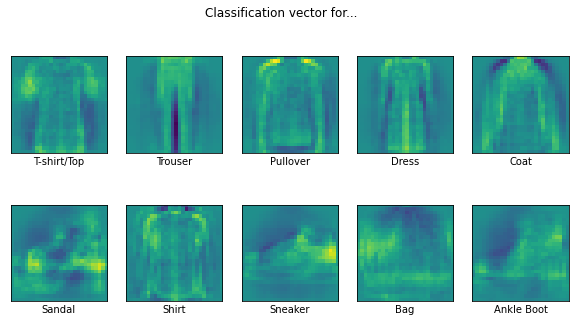

In [44]:
# plot 
coef = sag_lrm.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.viridis, vmin=-scale, vmax=scale) # cmap is the colormap
                                                              # vmin and vmac are the color range the cmap covers
                                                              # cmap=plt.cm.RdBu
                                                              # cmap=plt.cm.viridis
                                                              # cmap=plt.cm.plasma
                                                              # https://matplotlib.org/stable/gallery/color/colormap_reference.html
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel(label[i])
plt.suptitle('Classification vector for...')